In [1]:
%load_ext autoreload
%autoreload 2
from EventDriven.backtest import OptionSignalBacktest
import pandas as pd
import numpy as np
from IPython.display import clear_output
from copy import deepcopy


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-22 21:38:26 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [2]:
import json
keys = [8, 9, 10, 11, 12 ]
imports_trades = {key: {'trades': pd.read_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_trades_{key}.csv').iloc[:, 1:]} for key in keys}

for key in keys:
    with open(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_weights_{key}.json', 'r') as f:
        weights = json.load(f)
        symbol_list = imports_trades[key]['trades'].Ticker.unique()
        untraded_symbols = [s for s in weights.keys() if s not in imports_trades[key]['trades'].Ticker.unique()]
        for s in untraded_symbols:
            weights.pop(s)
        imports_trades[key]['weights'] = weights

In [3]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo
ending_capital = 20_000
capital_tracking = {}
objects = {}
for key in keys:
    initial_capital = ending_capital
    try:
        reasons = {
            x['reason']:0 for x in evb_backtest.portfolio.unprocessed_signals
        }

        for v in (evb_backtest.portfolio.unprocessed_signals):
            reasons[v['reason']] += 1
            print(v) 
        print(f"Reasons for unprocessed signals: {key}")
        print(reasons)
    except:
        pass

    print(f"Starting backtest for key: {key}, with initial capital: {initial_capital}")
    print(f"Current capital: {initial_capital}, Ending capital: {ending_capital}, Return: {((ending_capital - initial_capital) / initial_capital) * 100}%")

    ## Set the trades and weights
    trades_ = imports_trades[key]['trades']
    weights = imports_trades[key]['weights']
    objects[key] = {}
    print(weights)

    ## Produce max cash map
    max_cash = {}
    cash = 20_000
    for s, w in weights.items():
        if w * cash > 200:
            max_cash[s] = 2
        elif w * cash > 100:
            max_cash[s] = 1
        else:
            max_cash[s] = 0.5
    print(max_cash)

    ## Initialize the backtest class
    evb_backtest = OptionSignalBacktest(trades_, initial_capital=initial_capital)

    ## Set the attributes
    w_map = {x: w  * 0.75 for x, w in weights.items()} ## 75% of the weights for each stock
    evb_backtest.portfolio.weight_map = w_map
    evb_backtest.portfolio.weight_map
    evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
    evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
    evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
    evb_backtest.portfolio.order_settings = {'type': 'naked',
    'specifics': [{'direction': 'long',
    'rel_strike': .85,
    'dte': 365,
    'moneyness_width': 0.10},
    {'direction': 'short',
    'rel_strike': .80,
    'dte': 365,
    'moneyness_width': 0.10}
    ],
    'name': 'vertical_spread'}

    evb_backtest.portfolio.max_contract_price = max_cash ## Max cash for each
    evb_backtest.executor.commission_rate = 0.65/100 ## 0.65% commission rate
    evb_backtest.portfolio.min_moneyness_threshold = 5 ## Number of times to adjust moneyness
    evb_backtest.executor.max_slippage_pct = 0.075 ## 0.075% slippage
    evb_backtest.portfolio.roll_map = 30 ## Roll map
    evb_backtest.portfolio.moneyness_width_factor = .025 ## Moneyness width factor, amount to adjust the moneyness width by
    evb_backtest.portfolio.dte_reduction_factor = 30 ## DTE reduction factor, how much dte should be reduced and recheck orders
    evb_backtest.portfolio.min_acceptable_dte_threshold = 180 ## Minimum acceptable dte threshold before breaking order search

    custom_attr = {
    'max_cash': max_cash,
    'w_map': w_map,
    'initial_capital': initial_capital,
    'commission_rate': evb_backtest.executor.max_slippage_pct,
    'max_slippage_pct':evb_backtest.executor.commission_rate,
    'roll_map': evb_backtest.portfolio.roll_map,
    'dte_reduction_factor': evb_backtest.portfolio.dte_reduction_factor,
    'liquidity_threshold': evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold,
    'lookback': evb_backtest.portfolio.risk_manager.OrderPicker.lookback,
    'data_availability_threshold': evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold,
    'min_moneyness_threshold': evb_backtest.portfolio.min_moneyness_threshold,

    }
    ## Run the backtest
    evb_backtest.run()

    ## Get the ending capital
    ending_capital = evb_backtest.portfolio._equity['Total'][-1]
    # initial_capital = ending_capital
    capital_tracking[key] = ending_capital
    objects[key]['WEIGHTS'] = w_map
    objects[key]['END_CASH'] = ending_capital
    objects[key]['TEST_RESULT'] = {}
    objects[key]['TEST_RESULT']['BACKTESTER'] = evb_backtest.portfolio
    objects[key]['TEST_RESULT']['AGG'] = evb_backtest.portfolio.aggregate()
    objects[key]['CUSTOM_ATTR'] = custom_attr



    clear_output(wait=True)

Reasons for unprocessed signals: 12
{}
Starting backtest for key: 12, with initial capital: 82163.18260920249
Current capital: 82163.18260920249, Ending capital: 82163.18260920249, Return: 0.0%
{'TSLA': 0.13285856444949615, 'META': 0.11763798538677593, 'NFLX': 0.08637009747959587, 'AAPL': 0.0676151517402857, 'COST': 0.0720078264760282, 'AMZN': 0.04879875274933317, 'BA': 0.02991981454758278, 'SBUX': 0.025747839118105225}
{'TSLA': 2, 'META': 2, 'NFLX': 2, 'AAPL': 2, 'COST': 2, 'AMZN': 2, 'BA': 2, 'SBUX': 2}
Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['TSLA20260116C530'], 'short': ['TSLA20260116C540'], 'trade_id': '&L:TSLA20260116C530&S:TSLA20260116C540', 'close': 1.8250000000000028}, Date: 2025-01-03, Signal: SignalEvent type:LONG, symbol=TSLA, date:2025-01-03 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:TSLA20250103LONG
Max Contract Price: 2, Cash at Hand: 73.68355682140803
Cash at Hand 73.68355682140803 Close 1.8250000000000028

In [13]:
preferred_cols = ['Positions','EntryTime', 'ExitTime','Ticker','PnL', 'ReturnPct', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue',  'EntryPrice', 'ExitPrice', 'Quantity', 'SignalID', 'Duration']
objects[10]['TEST_RESULT']['AGG']._trades[preferred_cols]

,Positions,EntryTime,ExitTime,Ticker,PnL,ReturnPct,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,EntryPrice,ExitPrice,Quantity,SignalID,Duration
0,&L:SBUX20240119C115&S:SBUX20240119C120,2023-01-04,2023-03-14,SBUX,-494.181554,-0.364965,193.435862,122.838498,1344.951036,868.969483,193.435862,122.838498,7,SBUX20230104LONG,69
1,&L:BA20240119C225&S:BA20240119C230,2023-01-04,2023-09-11,BA,-23.124395,-0.114129,202.616265,179.491870,201.316265,180.791870,202.616265,179.491870,1,BA20230104LONG,250
2,&L:NVDA20240119C205&S:NVDA20240119C210,2023-01-19,2023-12-20,NVDA,2474.320911,1.399675,196.420253,471.344799,1756.082276,4253.803187,196.420253,471.344799,9,NVDA20230119LONG,335
3,&L:NFLX20240119C455&S:NFLX20240119C460,2023-01-24,2023-09-27,NFLX,-356.668835,-0.574752,155.140405,65.973197,615.361621,269.092786,155.140405,65.973197,4,NFLX20230124LONG,246
4,&L:META20240119C165&S:META20240119C170,2023-01-30,2023-12-20,META,612.332641,1.679462,182.300286,488.466606,362.000571,979.533213,182.300286,488.466606,2,META20230130LONG,324
5,&L:AMD20240119C100&S:AMD20240119C105,2023-02-02,2023-09-21,AMD,73.533866,0.052376,175.495449,184.687182,1393.563594,1487.897460,175.495449,184.687182,8,AMD20230202LONG,231
6,&L:AAPL20240119C170&S:AAPL20240119C175,2023-02-03,2023-02-27,AAPL,-259.646137,-0.221688,195.204174,151.929818,1163.425043,919.378906,195.204174,151.929818,6,AAPL20230203LONG,24
7,&L:AAPL20240315C170&S:AAPL20240315C175,2023-03-06,2023-10-26,AAPL,242.735436,0.250141,194.078908,242.625995,963.894539,1219.629974,194.078908,242.625995,5,AAPL20230306LONG,234
8,&L:SBUX20240119C115&S:SBUX20240119C120,2023-04-19,2023-05-04,SBUX,-186.948988,-0.235234,198.683993,151.946746,789.535971,612.986983,198.683993,151.946746,4,SBUX20230418LONG,15
9,&L:AMZN20240315C135&S:AMZN20240315C145,2023-04-28,2023-10-26,AMZN,268.862627,0.458264,195.566218,285.187094,582.798654,859.461282,195.566218,285.187094,3,AMZN20230428LONG,181


: 

In [5]:
capital_tracking

{8: 23742.992570885683,
 9: 15461.00728930185,
 10: 27481.61117877092,
 11: 82163.18260920249,
 12: 61299.46313618652}

In [6]:
41302/20_000

2.0651

In [7]:
# objects[11]['TEST_RESULT']['BACKTESTER'].plot_portfolio()
key = 12
eq = objects[key]['TEST_RESULT']['BACKTESTER']._equity
trades = objects[key]['TEST_RESULT']['BACKTESTER'].trades
transactions = objects[key]['TEST_RESULT']['BACKTESTER'].transactions
ob = objects[key]['TEST_RESULT']['BACKTESTER']
ob.plot_portfolio()

KeyError: 'NVDA'

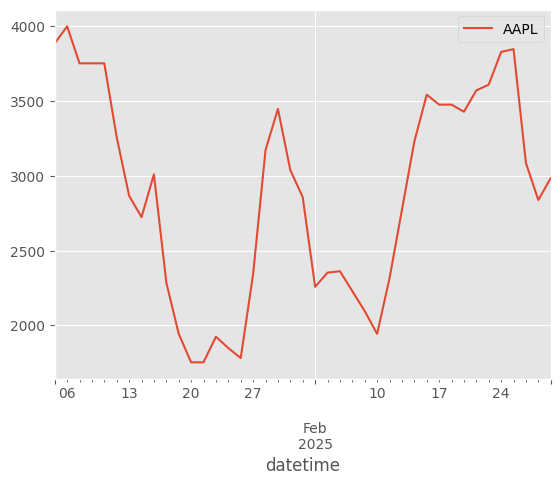

In [8]:
eq.plot(y = 'AAPL'), eq.plot(y = 'NVDA'), eq.plot(y = 'COST')

In [7]:
transactions

,signal_id,datetime,symbol,direction,cash_before,cash_after
0,BA20240103LONG,2024-01-03,BA,BUY,747.298116,219.613210
1,AAPL20240103LONG,2024-01-03,AAPL,BUY,1526.478628,262.705925
2,AMD20240103LONG,2024-01-03,AMD,BUY,2037.371505,350.875853
3,META20240103LONG,2024-01-03,META,BUY,1961.463552,282.330789
4,COST20240103LONG,2024-01-03,COST,BUY,1331.642892,127.663543
5,NFLX20240103LONG,2024-01-03,NFLX,BUY,824.674548,145.484407
6,NVDA20240112LONG,2024-01-12,NVDA,BUY,4073.120137,558.367806
7,BA20240103LONG,2024-01-17,BA,SELL,219.613210,363.303007
8,AMZN20240131LONG,2024-01-31,AMZN,BUY,408.430789,208.098788
9,SBUX20240212LONG,2024-02-12,SBUX,BUY,1086.400808,270.257419


In [8]:

trades[trades.Ticker == 'AAPL'][['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'Duration']]

,SignalID,Ticker,ReturnPct,Positions,EntryTime,ExitTime,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,Duration
1,AAPL20240103LONG,AAPL,-0.301643,&L:AAPL20250117C220&S:AAPL20241220C225,2024-01-03,2024-02-16,210.628784,147.094075,1255.972703,890.364450,44
10,AAPL20240513LONG,AAPL,0.775969,&L:AAPL20250620C205&S:AAPL20250620C210,2024-05-13,2024-12-31,205.726732,365.364251,1022.133658,1833.321256,232


<Axes: xlabel='Datetime'>

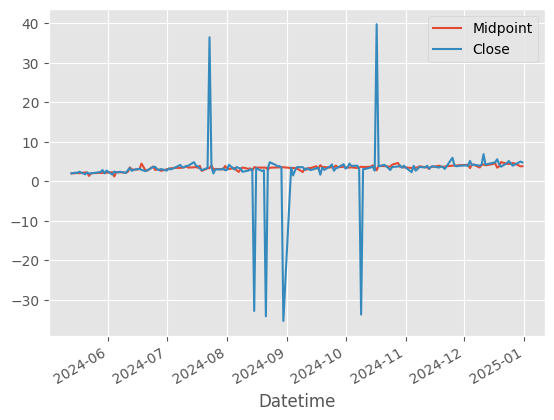

In [9]:
opt_data = objects[11]['TEST_RESULT']['BACKTESTER'].options_data['AAPL20250620C205'] - objects[11]['TEST_RESULT']['BACKTESTER'].options_data['AAPL20250620C210']
opt_data[(opt_data.index >= '2024-05-13') & (opt_data.index <= '2024-12-31')].plot(y = ['Midpoint', 'Close'])

In [10]:
from dbase.DataAPI.ThetaData import retrieve_eod_ohlc,retrieve_quote
retrieve_quote('NVDA', 
                  '2024-12-20',
                  '2025-01-17',
                  'C',
                  '2024-01-12',
                  595.0,
                  print_url=True)

http://127.0.0.1:25510/v2/hist/option/quote?end_date=20241220&root=NVDA&use_csv=true&exp=20250117&ivl=1800000&right=C&start_date=20240112&strike=595000&start_time=34200000&rth=False&end_time=57600000


,Bid_size,Bid_exchange,Bid,Bid_condition,Ask_size,Ask_exchange,Ask,Ask_condition,Date,Midpoint,Weighted_midpoint,time
datetime,,,,,,,,,,,,
2024-01-12 09:30:00,0,1,0.00,50,0,1,0.00,50,20240112,0.000,NaN,09:30:00
2024-01-12 10:00:00,18,73,81.90,50,37,5,82.35,50,20240112,82.125,82.202727,10:00:00
2024-01-12 10:30:00,15,69,81.95,50,28,69,82.40,50,20240112,82.175,82.243023,10:30:00
2024-01-12 11:00:00,19,69,80.70,50,53,5,81.05,50,20240112,80.875,80.957639,11:00:00
2024-01-12 11:30:00,23,69,81.85,50,25,46,82.15,50,20240112,82.000,82.006250,11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10 14:00:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,14:00:00
2024-06-10 14:30:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,14:30:00
2024-06-10 15:00:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,15:00:00


In [11]:
retrieve_eod_ohlc?

Signature:
retrieve_eod_ohlc(
    symbol,
    end_date: str,
    exp: str,
    right: str,
    start_date: str,
    strike: float,
    print_url=False,
    rt=True,
    proxy='http://18.232.166.224:5500/thetadata',
    **kwargs,
)
Docstring: Interval size in miliseconds. 1 minute is 6000
File:      ~/cloned_repos/FinanceDatabase/dbase/DataAPI/ThetaData.py
Type:      function

In [12]:
objects[11]['TEST_RESULT']['AGG']

Start                                                    2024-01-03 00:00:00
End                                                      2024-12-31 00:00:00
Duration                                                   363 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    55008.92
Equity Peak [$]                                                 92562.581779
Return [%]                                                        160.789903
Buy & Hold Return [%]                                               54.89812
CAGR [%]                                                           162.17084
Volatility Ann. [%]                                               169.099939
Sharpe Ratio                                                        1.381638
Sortino Ratio                                                       2.085216
Skew                                                                1.047743

In [13]:
objects[9]

{'WEIGHTS': {'NVDA': 0.193113327353184,
  'TSLA': 0.10597235406416428,
  'AMD': 0.06088781342963995,
  'AAPL': 0.09449359902353249,
  'NFLX': 0.05972035693343455,
  'COST': 0.06444958682546627,
  'AMZN': 0.043240968324206666,
  'BA': 0.0467708109001976,
  'SBUX': 0.04668659972930734},
 'END_CASH': 15014.71964973706,
 'TEST_RESULT': {'BACKTESTER': <EventDriven.portfolio.OptionSignalPortfolio at 0x143267f50>,
  'AGG': Start                                                    2022-01-04 00:00:00
  End                                                      2022-12-30 00:00:00
  Duration                                                   360 days 00:00:00
  Exposure Time [%]                                                      77.61
  Equity Final [$]                                                    15014.72
  Equity Peak [$]                                                 23475.760782
  Return [%]                                                        -34.198667
  Buy & Hold Return [%]      

In [14]:
imports_trades[9]['trades'].PnL.sum(),imports_trades[9]['trades'].PnL.shape

(-12953.237079659477, (21,))

In [15]:

imports_trades[9]['weights']['NVDA'] * 20000

5149.688729418241